## Import Modules

In [41]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/dominicbates/Documents/Github/statistical-analysis-templates/')
from useful_functions import marginals_hist

## Create some fake data

In [68]:
data_size = 200

# Sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))
    
# Create three independant variables
np.random.seed(0)
f1 = np.random.randn(data_size)/2
f2 = np.random.randn(data_size)/2
f3 = np.random.randn(data_size)/2

# Sum linearly and pass through sigmoid
probabilities = sigmoid((2*f1) + (1*f2) + (-1*f3) + 0.2)

# Randomly assign values from probabilites
out = (probabilities > np.random.rand(data_size)).astype(int)

In [69]:
df = pd.DataFrame({
    'feature_1':f1,
    'feature_2':f2,
    'feature_3':f3,
    'target':out
})

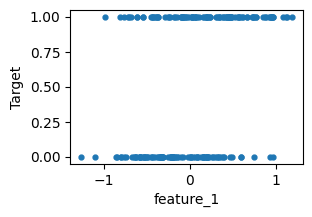

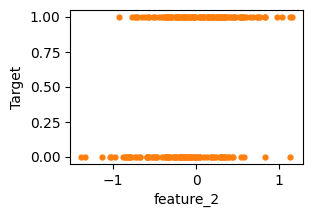

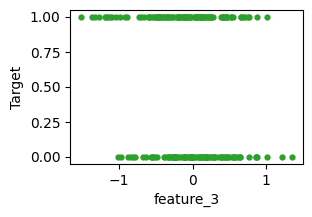

In [70]:
count = 0
for feature in [f for f in list(df) if f!='target']:
    plt.figure(figsize=(3,2))
    plt.plot(df[feature], df['target'], f'C{count}.', markersize=7)
    plt.ylabel('Target')
    plt.xlabel(feature)
    count+=1

## Fit Bayesian logistic regression model

In [98]:
# Define features and target
features = ['feature_1', 'feature_2', 'feature_3']
target = 'target'

# Define data
X = df[features]
y = df[target]  # Ensure target is binary (0/1)

# Define model
with pm.Model() as logistic_model:
    # Priors for coefficients and intercept
    intercept = pm.Normal('intercept', mu=0, sigma=10)  # Prior on intercept
    betas = pm.Normal('betas', mu=0, sigma=10, shape=len(features))  # Priors on coefficients

    # Linear predictor
    linear_combination = intercept + pm.math.dot(X, betas)

    # Likelihood uses probabilities from the sigmoid transformation of the linear predictor
    y_obs = pm.Bernoulli('y_obs', p=pm.math.sigmoid(linear_combination), observed=y)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.



#### Extensions to non-binary outcomes

Logistic regression only works for modelling binary outcomes. If modelling e.g. a proportion, then use Beta regression or Gaussian regression instead. Here, you  model as a linear combination of values, passed through a sigmoid as above, however, you *cannot* use a Bernoulli error (since this assumes binary outcomes). 

You can instead model the error with a beta distribution e.g. like `y_obs = pm.Beta('y_obs', mu=pm.math.sigmoid(linear_combination), sigma=phi, observed=y)` or alternatively a gaussian (which is possibly less correct since then values can be < 0 or > 1). And you'd also need to add a prior for the dispersion (e.g. `phi`) like `phi = pm.HalfNormal('phi', sigma=10)`. This would then allow you to model values between 0 and 1 using a GLM + sigmoid, similarly to logistic regression, but modelling the error correctly.

## Plot model summary

In [73]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.22,0.18,-0.10,0.56,0.0,0.0,9225.18,6667.05,1.0
betas[0],1.81,0.38,1.09,2.50,0.0,0.0,9857.04,6131.41,1.0
betas[1],1.88,0.40,1.14,2.66,0.0,0.0,9284.06,6001.50,1.0
betas[2],-1.30,0.36,-1.98,-0.61,0.0,0.0,10476.92,6726.88,1.0


## Trace summary

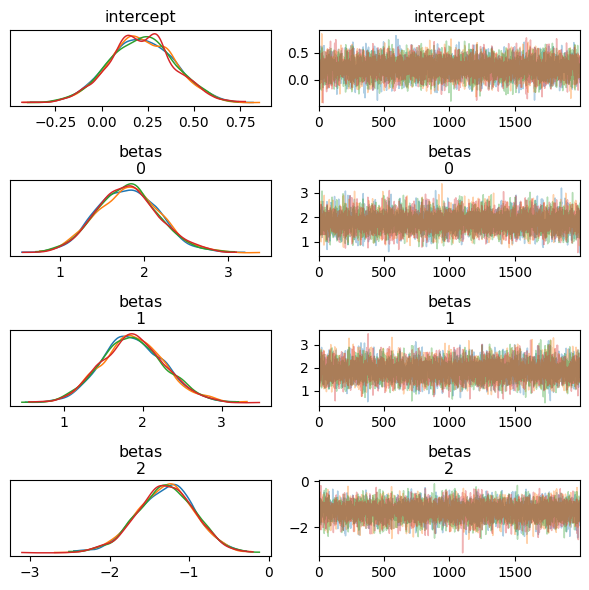

In [95]:
names = features + ["intercept", "sigma"]
pm.plot_trace(trace, figsize=(6,6), compact=False);
plt.tight_layout()

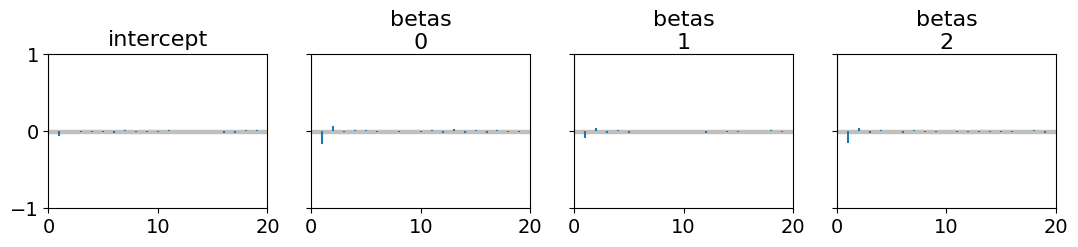

In [88]:
# Check for autocorrelation
az.plot_autocorr(trace, max_lag=20, combined=True, figsize=(13,2));

## Pair plot

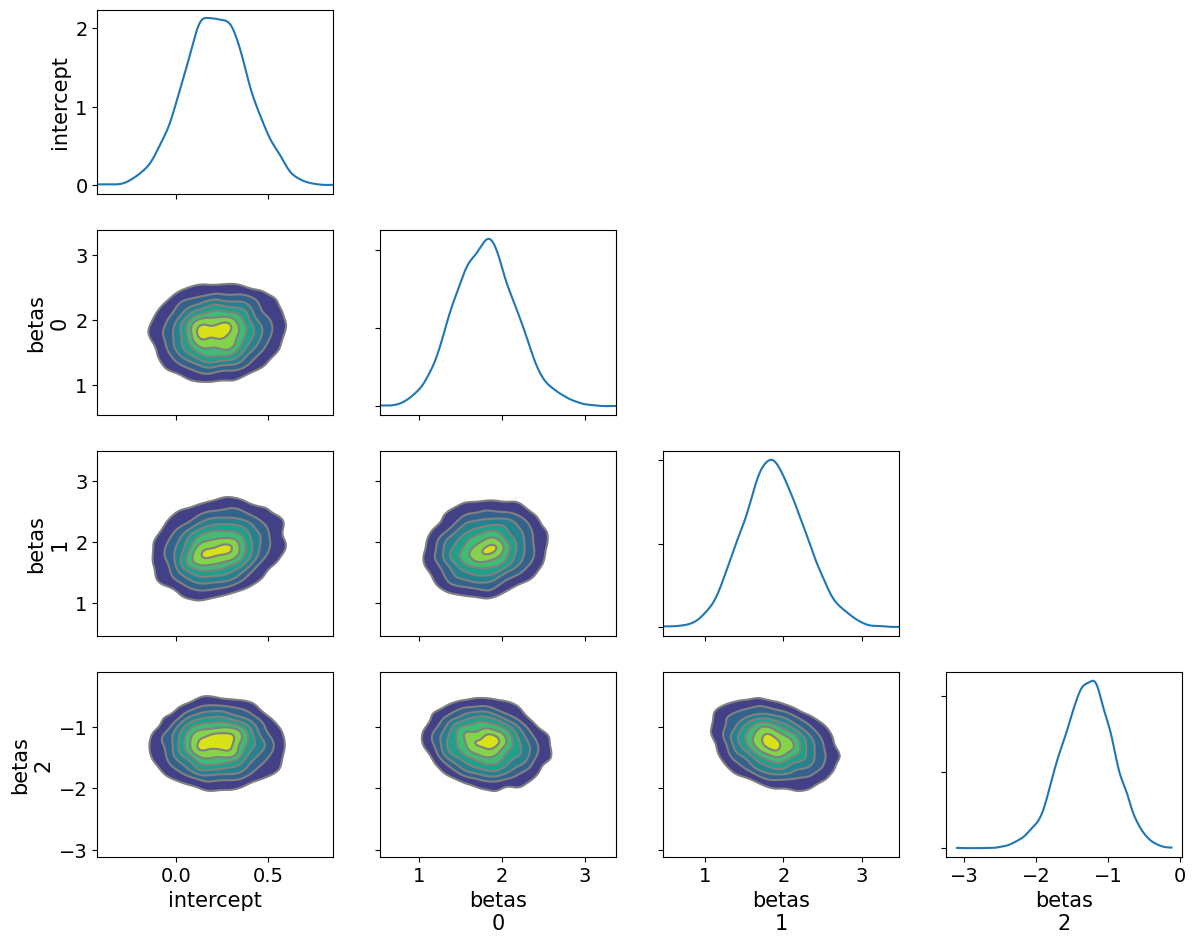

In [75]:
# Plot pair plot and marginals
az.plot_pair(trace, kind='kde', marginals=True, figsize=(14,11));


## Plot marginals distributions

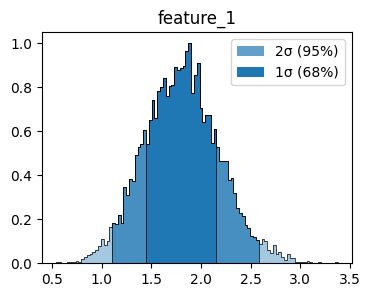

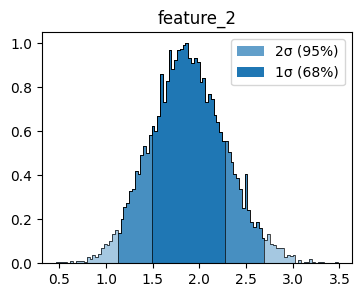

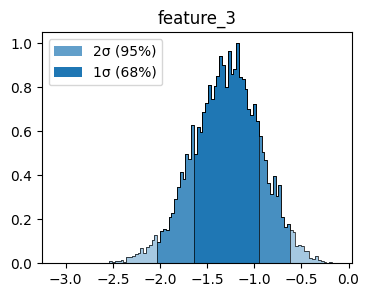

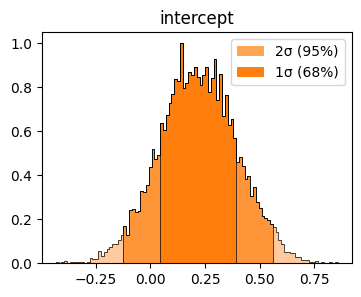

In [76]:
# Plot betas
for n in range(len(features)):
    vals = trace.posterior.betas.values[:,:,n].flatten()
    marginals_hist(vals, features[n])

# Plot intercept
vals = trace.posterior.intercept.values.flatten()
marginals_hist(vals, 'intercept', color='C1')

# # Plot sigma (noise)
# vals = trace.posterior.sigma.values.flatten()
# marginals_hist(vals, 'sigma', color='C2')

## Test some hypothesss

In [96]:
# Compute P(beta_1 > beta_2)
p_b2_gtr_b3 = np.mean(trace.posterior.betas.values[:,:,1] > trace.posterior.betas.values[:,:,2])

# # Compute P(ntercept > 0)
p_int_gtr_zero = np.mean(trace.posterior.intercept.values > 0)
p_b3_gtr_zero = np.mean(trace.posterior.betas.values[:,:,2] > 0)


In [97]:
print(f'Prob f2 > f3: {p_b2_gtr_b3:.3f}')
print(f'Prob f3 > 0: {p_b3_gtr_zero:.3f}')
print(f'Prob intercept > 0: {p_int_gtr_zero:.3f}')

Prob f2 > f3: 1.000
Prob f3 > 0: 0.000
Prob intercept > 0: 0.893


### Summary